<a href="https://colab.research.google.com/github/AnuragSharma5893/Sleep-Stage-Classification_using_ML/blob/main/Sleep_Stage_Classification_from_EEG_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sleep Stage Classification using EEG Data
**Data type:** Timeserie

**Data Source:**
The data comes from one of the sleep physionet dataset that comes from this study [" Age and Gender Affect Different Characteristics of Slow Waves in the Sleep EEG "](https://academic.oup.com/sleep/article/18/7/557/2749691?login=false).

> This corresponds to a subset of 153 recordings from 37 males and 41 females that were 25-101 years old at the time of the recordings. There are two night recordings per subject except for subjects 13, 36 and 52 which have one record missing each due to missing recording hardware.

The format of the recording is in EDF, more information can be found on this video: [What is the EDF/EDF+ Data Format](https://www.youtube.com/watch?v=DI7zfksrsCo) .

**Channel type:**
- Electroencephalography (EEG)
- Electrooculography (EOG)
- Respiration
- Electromyography (EMG)
- Temperature

**The label type:** annotation from expert between 6 stages:

**Label category:**
- Wake (W)
- Sleep Stage 1
- Sleep Stage 2
- Sleep Stage 3/4
- Sleep REM (R)

**The classification problem is the following:**

Given the multimodal time serie, detect which sleep stage an **unseen** participant is in any given 30 second epoch.

**The validation methodology:**

If we wants to have a machine learning model that perform on unseen participant, we need to validate the model with a leave-X-participant-out cross validation scheme.

For our purpose we will use a **leave-one-participant-out** cross-validation scheme.

**Main code and analysis comes from:**
- [A Deep Learning Architecture for Temporal Sleep Stage Classification Using Multivariate and Multimodal Time Series](https://ieeexplore.ieee.org/document/8307462)
- [Code from MNE Python Tutorial](https://mne.tools/stable/auto_tutorials/clinical/60_sleep.html#sphx-glr-auto-tutorials-clinical-60-sleep-py)
- [Age and Gender Affect Different Characteristics of Slow Waves in the Sleep EEG](https://academic.oup.com/sleep/article/18/7/557/2749691?login=false)

**About MNE Python:**

MNE Python is an opensource Python library to analyse neurophysiological data.
You can check out more [over here](https://mne.tools/stable/index.html).

# Analysis for 10 participants with 3 sleep stage classification

In [ ]:
# Installing MNE Python
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 43.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import LeaveOneGroupOut

import mne
from mne.datasets.sleep_physionet.age import fetch_data

In [ ]:
# Experiment variables

# classification label target
EVENT_ID = {
    "Sleep stage W": 1,
    "Sleep stage 1/2/3/4": 2,
    "Sleep stage R": 3,
}

# Frequency bands range in Hz for EEG
FREQ_BANDS = {
    "delta": [0.5, 4.5],
    "theta": [4.5, 8.5],
    "alpha": [8.5, 11.5],
    "sigma": [11.5, 15.5],
    "beta": [15.5, 30],
}

# Number of participants used in the analysis
NUM_PARTICIPANT = 10

# Step 1: Loading the Data and Preprocessing

In [ ]:
def load_data(participant_id, event_id=EVENT_ID):
  """ Will load the EDF with annotation for a given participant and create
      30 seconds epochs

  Parameters
  ----------
  participant_id:
    The subjects to use. Can be in the range of 0-82 (inclusive), however the
    following subjects are not available: 39, 68, 69, 78 and 79.


  Return
  ----------
  raw_edf:
    Contains the edf with the annotations
  events:
    Contains the 30 seconds events
  epochs:
    the 30 seconds epoch

  Limitation:
  -----------
    Will only get 1 recording session
    Will only work for 1 subject at a time
  """

  ANNOTATION_EVENT_ID = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 2,
    "Sleep stage 3": 2,
    "Sleep stage 4": 2,
    "Sleep stage R": 3,
  }

  # Load two file paths, one for the signal and one for the annotations
  [participant_file] = fetch_data(subjects=[participant_id], recording=[1])

  # Read the signal file with information on each signal
  raw_edf = mne.io.read_raw_edf(
    participant_file[0],
    stim_channel="Event marker",
    infer_types=True,
    preload=True,
    verbose="error"
  )

  # Read the annotation file
  annotation_edf = mne.read_annotations(participant_file[1])

  # keep last 4h wake events before sleep and first 4h wake events after
  # sleep and redefine annotations on raw data
  annotation_edf.crop(annotation_edf[1]["onset"] - 30 * 240, annotation_edf[-2]["onset"] + 30 * 240)

  # Attach the annotation file to the raw edf loaded
  raw_edf.set_annotations(annotation_edf, emit_warning=False)

  # Chunk the data into 30 seconds epochs
  events, _ = mne.events_from_annotations(
      raw_edf, event_id=ANNOTATION_EVENT_ID, chunk_duration=30.0
  )


  # Create the epochs so that we can use it for classification
  tmax = 30.0 - 1.0 / raw_edf.info["sfreq"]  # tmax in included

  epochs = mne.Epochs(
      raw=raw_edf,
      events=events,
      event_id=event_id,
      tmin=0.0,
      tmax=tmax,
      baseline=None,
      preload=True,
  )

  return raw_edf, events, epochs

# Load NUM_PARTICIPANT data and store them for further processing
all_participant_epochs = []
for participant_id in range(NUM_PARTICIPANT):
  _, _, epochs = load_data(participant_id=participant_id)
  all_participant_epochs.append(epochs)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data


100%|█████████████████████████████████████| 48.3M/48.3M [00:00<00:00, 18.1GB/s]
100%|█████████████████████████████████████| 4.62k/4.62k [00:00<00:00, 1.53MB/s]

Download complete in 01m58s (46.1 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1201 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.1M/51.1M [00:00<00:00, 28.4GB/s]
100%|█████████████████████████████████████| 3.90k/3.90k [00:00<00:00, 1.39MB/s]

Download complete in 01m31s (48.7 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1463 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1463 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.1M/51.1M [00:00<00:00, 16.2GB/s]
100%|█████████████████████████████████████| 4.80k/4.80k [00:00<00:00, 2.09MB/s]

Download complete in 01m32s (48.8 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1385 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1385 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.4M/51.4M [00:00<00:00, 5.20GB/s]
100%|██████████████████████████████████████| 3.70k/3.70k [00:00<00:00, 730kB/s]

Download complete in 01m33s (49.1 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1312 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1312 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 46.9M/46.9M [00:00<00:00, 17.3GB/s]
100%|█████████████████████████████████████| 4.83k/4.83k [00:00<00:00, 2.00MB/s]

Download complete in 01m24s (44.7 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1595 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1595 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 49.7M/49.7M [00:00<00:00, 13.6GB/s]
100%|█████████████████████████████████████| 3.98k/3.98k [00:00<00:00, 1.29MB/s]

Download complete in 01m26s (47.4 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1032 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1032 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 50.5M/50.5M [00:00<00:00, 14.3GB/s]
100%|██████████████████████████████████████| 2.62k/2.62k [00:00<00:00, 781kB/s]

Download complete in 01m28s (48.2 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1203 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1203 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.3M/51.3M [00:00<00:00, 13.5GB/s]
100%|█████████████████████████████████████| 3.63k/3.63k [00:00<00:00, 1.31MB/s]

Download complete in 01m27s (48.9 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1336 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1336 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.0M/51.0M [00:00<00:00, 22.8GB/s]
100%|█████████████████████████████████████| 4.31k/4.31k [00:00<00:00, 1.71MB/s]

Download complete in 01m30s (48.6 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1494 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1494 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 49.8M/49.8M [00:00<00:00, 15.5GB/s]
100%|█████████████████████████████████████| 4.47k/4.47k [00:00<00:00, 1.29MB/s]

Download complete in 01m28s (47.5 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1492 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1492 events and 3000 original time points ...
0 bad epochs dropped


In [ ]:
all_participant_epochs

[<Epochs |  1201 events (all good), 0 – 29.99 s, baseline off, ~192.4 MB, data loaded,
  'Sleep stage W': 548
  'Sleep stage 1/2/3/4': 528
  'Sleep stage R': 125>,
 <Epochs |  1463 events (all good), 0 – 29.99 s, baseline off, ~234.4 MB, data loaded,
  'Sleep stage W': 517
  'Sleep stage 1/2/3/4': 776
  'Sleep stage R': 170>,
 <Epochs |  1385 events (all good), 0 – 29.99 s, baseline off, ~221.9 MB, data loaded,
  'Sleep stage W': 488
  'Sleep stage 1/2/3/4': 734
  'Sleep stage R': 163>,
 <Epochs |  1312 events (all good), 0 – 29.99 s, baseline off, ~210.2 MB, data loaded,
  'Sleep stage W': 500
  'Sleep stage 1/2/3/4': 603
  'Sleep stage R': 209>,
 <Epochs |  1595 events (all good), 0 – 29.99 s, baseline off, ~255.6 MB, data loaded,
  'Sleep stage W': 560
  'Sleep stage 1/2/3/4': 839
  'Sleep stage R': 196>,
 <Epochs |  1032 events (all good), 0 – 29.99 s, baseline off, ~165.4 MB, data loaded,
  'Sleep stage W': 568
  'Sleep stage 1/2/3/4': 396
  'Sleep stage R': 68>,
 <Epochs |  1203 

# Step 2: Feature Calculation

In [ ]:
def eeg_power_band(epochs, freq_bands=FREQ_BANDS):
  """Calculate relative spectral analysis on the EEG sensors for each epochs"""

  # Calculate the spectrogram
  spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
  psds, freqs = spectrum.get_data(return_freqs=True)

  # Normalization
  psds /= np.sum(psds, axis=-1, keepdims=True)

  # shape of PSDS:
  # (epoch, number of channels (we have two), frequency_bins)
  # We'll slice and average to get the delta to theta bands (5 feature per channel)
  # Therefore we should finish with (epoch, number of channels * number of bands)

  X = []
  # For each frequency band get the mean value and add it to the list X
  for fmin, fmax in freq_bands.values():
    psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
    X.append(psds_band.reshape(len(psds), -1))

  # return a numpy array, by reshuffling the list from a (5,841,2) to a (841,10)
  return np.concatenate(X, axis=1)

In [ ]:
# Iterate over the 30 seconds epochs, calculate the proper powerband features
# Then define the right id for the "group" which should be the participant_id

X = []
y = []
groups = []
for group_id, epochs in enumerate(all_participant_epochs):
  print(f"Processing participants #{group_id}")

  X_epoch = eeg_power_band(epochs)
  y_epoch = epochs.events[:, 2]
  group_epoch = [group_id]*len(y_epoch)

  X.append(X_epoch)
  y.append(y_epoch)
  groups.append(group_epoch)

# Transform these lists into numpy array with proper size for sklearn models
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)
groups = np.concatenate(groups, axis=0)

Processing participants #0
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #1
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #2
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #3
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #4
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #5
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #6
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #7
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #8
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #9
    Using multitaper spectrum estimation with 7 DPSS windows


Testing on participant: #0
Accuracy score: 0.8792672772689425
                     precision    recall  f1-score   support

      Sleep stage W       1.00      0.86      0.92       548
Sleep stage 1/2/3/4       0.86      0.92      0.89       528
      Sleep stage R       0.60      0.78      0.67       125

           accuracy                           0.88      1201
          macro avg       0.82      0.85      0.83      1201
       weighted avg       0.90      0.88      0.88      1201

{'Sleep stage W': 1, 'Sleep stage 1/2/3/4': 2, 'Sleep stage R': 3}
Testing on participant: #1
Accuracy score: 0.885850991114149
                     precision    recall  f1-score   support

      Sleep stage W       0.85      0.99      0.92       517
Sleep stage 1/2/3/4       0.96      0.83      0.89       776
      Sleep stage R       0.74      0.82      0.78       170

           accuracy                           0.89      1463
          macro avg       0.85      0.88      0.86      1463
       weigh

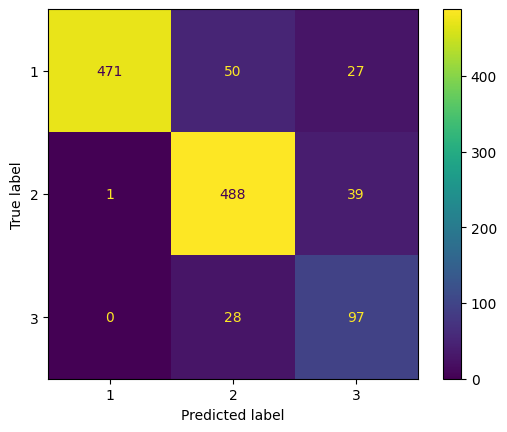

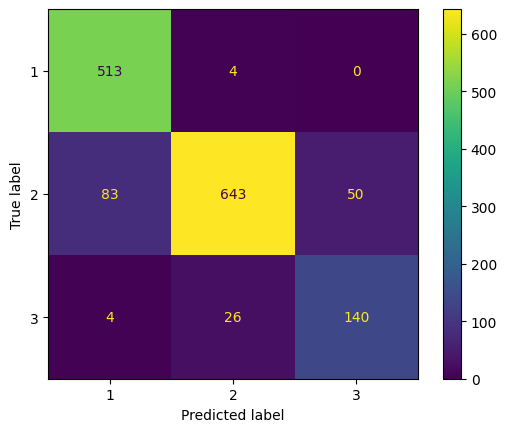

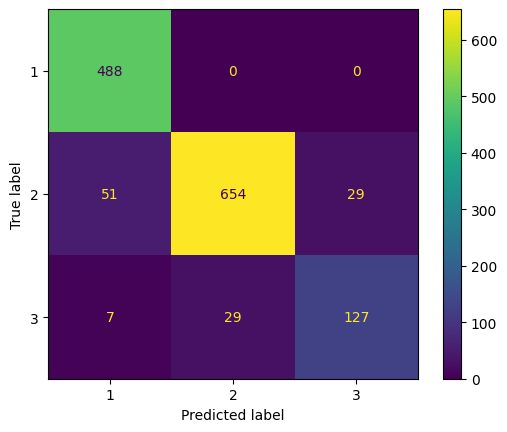

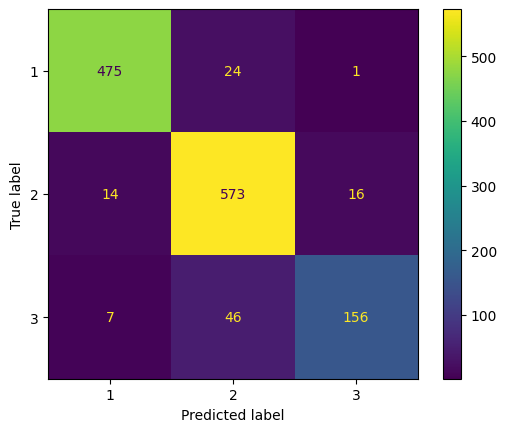

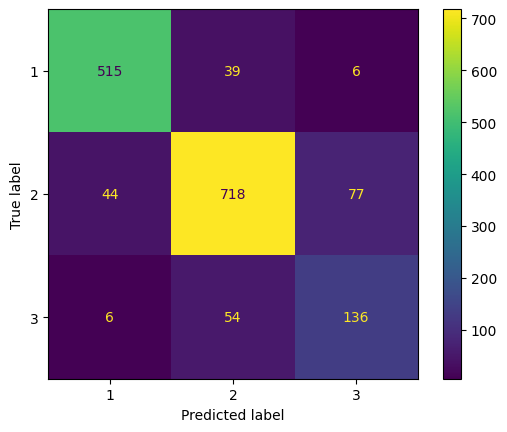

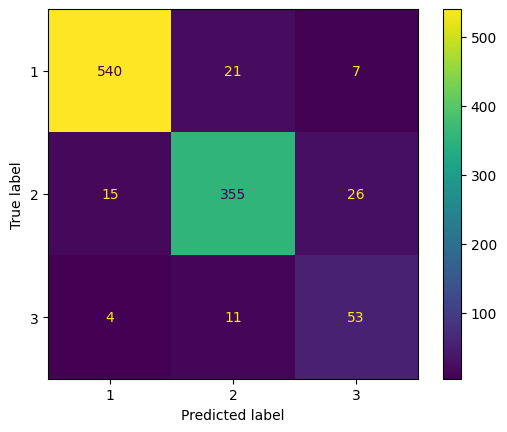

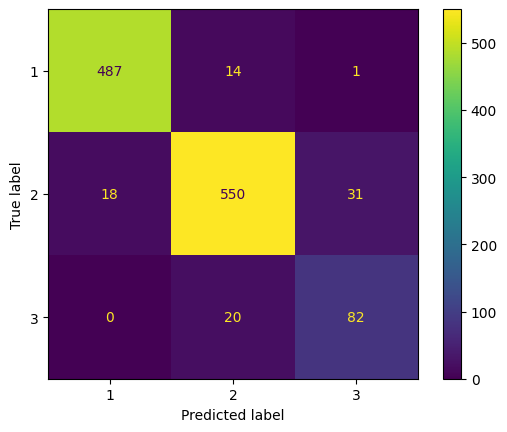

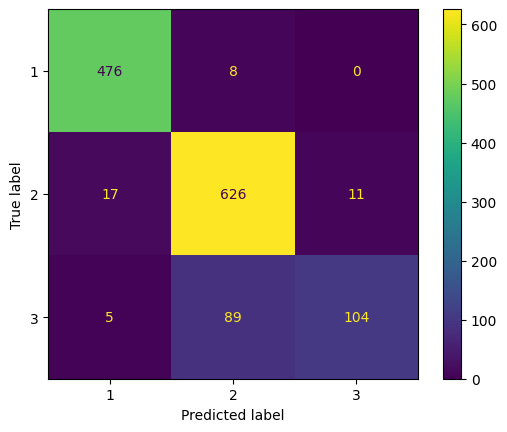

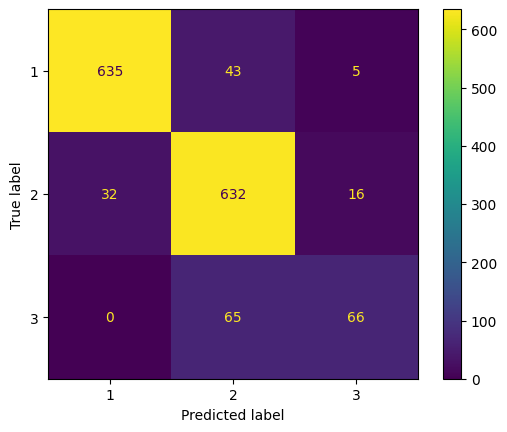

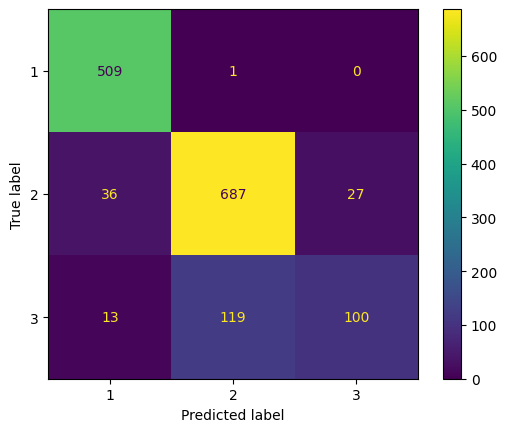

In [ ]:
# Leave One Participant Out Cross Validation, using group_id == participant_id
logo = LeaveOneGroupOut()

group_id = 0
for train, test in logo.split(X, y, groups=groups):
  print(f"Testing on participant: #{group_id}")
  group_id = group_id + 1

  # Training of the classifier
  model = RandomForestClassifier(n_estimators=100, random_state=42)
  X_train = X[train]
  y_train = y[train]
  model.fit(X_train, y_train)

  # Testing using the current participant data left out
  X_test = X[test]
  y_test = y[test]
  y_pred = model.predict(X_test)

  acc = accuracy_score(y_test, y_pred)

  print(f"Accuracy score: {acc}")

  # Create a confusion matrix and a report on all the metrics
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  disp.plot() # will appear at the end of the output

  print(classification_report(y_test, y_pred, target_names=EVENT_ID.keys()))
  print(EVENT_ID)


## Analysis Steps for Two Participants with One Recording for Binary State


In [ ]:
# Experiment variables

# classification label target
EVENT_ID = {
    "Awake": 1,
    "Sleeping": 2,
}

FREQ_BANDS = {
    "delta": [0.5, 4.5],
    "theta": [4.5, 8.5],
    "alpha": [8.5, 11.5],
    "sigma": [11.5, 15.5],
    "beta": [15.5, 30],
}

**bold text**# Step 1: Loading the Data and Preprocessing

In [ ]:
def load_data(participant_id, event_id=EVENT_ID):
  """ Will load the EDF with annotation for a given participant and create
      30 seconds epochs

  Parameters
  ----------
  participant_id:
    The subjects to use. Can be in the range of 0-82 (inclusive), however the
    following subjects are not available: 39, 68, 69, 78 and 79.


  Return
  ----------
  raw_edf:
    Contains the edf with the annotations
  events:
    Contains the 30 seconds events
  epochs:
    the 30 seconds epoch

  Limitation:
  -----------
    Will only get 1 recording session
    Will only work for 1 subject at a time
  """

  ANNOTATION_EVENT_ID = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 2,
    "Sleep stage 3": 2,
    "Sleep stage 4": 2,
    "Sleep stage R": 2,
  }

  # Load two file paths, one for the signal and one for the annotations
  [participant_file] = fetch_data(subjects=[participant_id], recording=[1])

  # Read the signal file with information on each signal
  raw_edf = mne.io.read_raw_edf(
    participant_file[0],
    stim_channel="Event marker",
    infer_types=True,
    preload=True,
    verbose="error"
  )

  # Read the annotation file
  annotation_edf = mne.read_annotations(participant_file[1])

  # keep last 4h wake events before sleep and first 4h wake events after
  # sleep and redefine annotations on raw data
  annotation_edf.crop(annotation_edf[1]["onset"] - 30 * 240, annotation_edf[-2]["onset"] + 30 * 240)

  # Attach the annotation file to the raw edf loaded
  raw_edf.set_annotations(annotation_edf, emit_warning=False)

  # Chunk the data into 30 seconds epochs
  events, _ = mne.events_from_annotations(
      raw_edf, event_id=ANNOTATION_EVENT_ID, chunk_duration=30.0
  )


  # Create the epochs so that we can use it for classification
  tmax = 30.0 - 1.0 / raw_edf.info["sfreq"]  # tmax in included

  epochs = mne.Epochs(
      raw=raw_edf,
      events=events,
      event_id=event_id,
      tmin=0.0,
      tmax=tmax,
      baseline=None,
      preload=True,
  )

  return raw_edf, events, epochs

# The training participant will be the one with ID 0 for now
raw_train, events_train, epochs_train = load_data(participant_id=0)
# The test participant will be the one with ID 1 for now
raw_test, events_test, epochs_test = load_data(participant_id=1)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1201 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1463 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1463 events and 3000 original time points ...
0 bad epochs dropped


In [ ]:
print("Training data EDF loaded and structured.")
raw_train

Training data EDF loaded and structured.


Measurement date,"April 24, 1989 16:13:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,"2 EEG, 1 EOG, 1 Respiration monitoring channel, 1 EMG, 1 Temperature, 1 Stimulus"
Bad channels,None
EOG channels,horizontal
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.00 Hz
Lowpass,50.00 Hz


In [ ]:
print("Training data epochs loaded and structured.")
epochs_train

Training data epochs loaded and structured.


Number of events,1201
Events,Awake: 548Sleeping: 653
Time range,0.000 – 29.990 s
Baseline,off


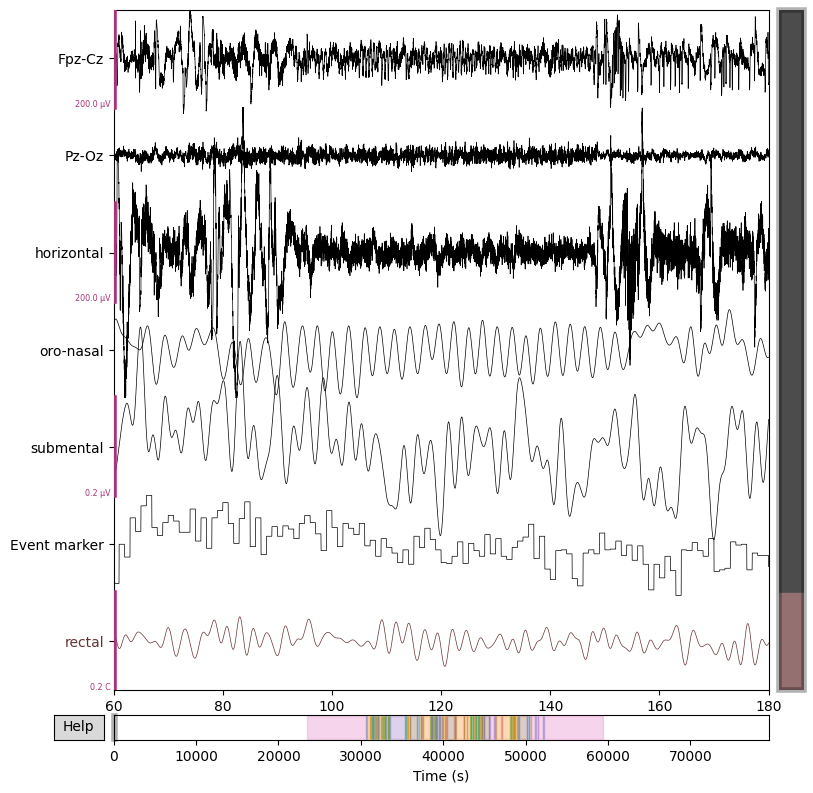

Plot showing the signals form the participant 1


In [ ]:
# Plot the data
raw_train.plot(
    start=60,
    duration=120,
    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1)
)
print("Plot showing the signals form the participant 1")

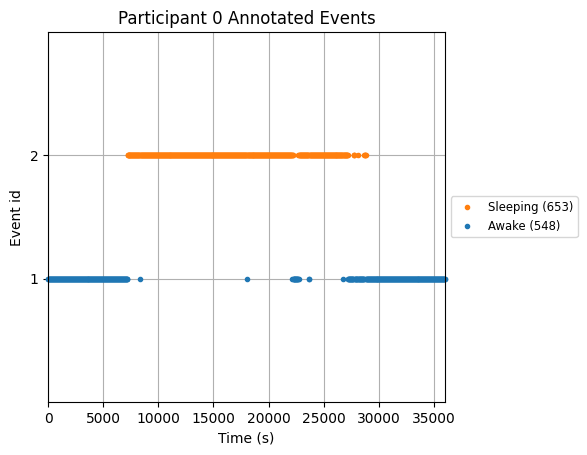

In [ ]:
# plot events across time
fig = mne.viz.plot_events(
    events_train,
    event_id=EVENT_ID,
    sfreq=raw_train.info["sfreq"],
    first_samp=events_train[0, 0],
    show=False,
)
ax = fig.gca()

# Modify the plot a bit
ax.set_title("Participant 0 Annotated Events")

# keep the color-code for further plotting
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


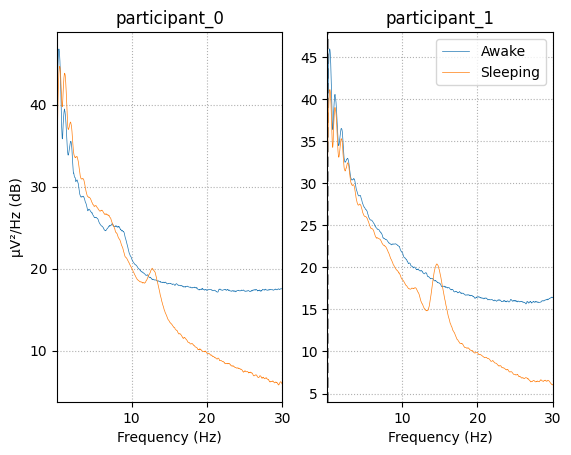

In [ ]:
# visualize participant 0 vs participant 1 PSD by sleep stage
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(EVENT_ID.keys())

for ax, title, epochs in zip([ax1, ax2], ["participant_0", "participant_1"], [epochs_train, epochs_test]):
  for stage, color in zip(stages, stage_colors):
    spectrum = epochs[stage].compute_psd(fmin=0.1, fmax=30.0)
    spectrum.plot(
        ci=None,
        color=color,
        axes=ax,
        show=False,
        average=True,
        amplitude=False,
        spatial_colors=False,
        picks="data",
        exclude="bads",
    )
  ax.set(title=title, xlabel="Frequency (Hz)")
ax1.set(ylabel="µV²/Hz (dB)")
ax2.legend(ax2.lines[2::3], stages)

# Step 2: Feature Calculation

In [ ]:
def eeg_power_band(epochs, freq_bands=FREQ_BANDS):
  """Calculate relative spectral analysis on the EEG sensors for each epochs"""

  # Calculate the spectrogram
  spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
  psds, freqs = spectrum.get_data(return_freqs=True)

  # Normalization
  psds /= np.sum(psds, axis=-1, keepdims=True)

  # shape of PSDS:
  # (epoch, number of channels (we have two), frequency_bins)
  # We'll slice and average to get the delta to theta bands (5 feature per channel)
  # Therefore we should finish with (epoch, number of channels * number of bands)

  X = []
  # For each frequency band get the mean value and add it to the list X
  for fmin, fmax in freq_bands.values():
    psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
    X.append(psds_band.reshape(len(psds), -1))

  # return a numpy array, by reshuffling the list from a (5,841,2) to a (841,10)
  return np.concatenate(X, axis=1)

# Step 3: Classification

In [ ]:
# Define beforehand what is random here for each of the stage given the data we have.
# This is for the training participant
stages = sorted(EVENT_ID.keys())
random_guess_train = {}
for stage in stages:
  random_guess_train[stage] = len(epochs_train[stage]) / len(epochs_train)

print("Random guess for the training participant: ")
random_guess_train

Random guess for the training participant: 


{'Awake': 0.4562864279766861, 'Sleeping': 0.5437135720233139}

In [ ]:
random_guess_test = {}
for stage in stages:
  random_guess_test[stage] = len(epochs_test[stage]) / len(epochs_test)

print("Random guess for the testing participant: ")
random_guess_test

Random guess for the testing participant: 


{'Awake': 0.3533834586466165, 'Sleeping': 0.6466165413533834}

In [ ]:
# Our Steps are:
# 1. create the feature vector X using the epochs
# 2. Use the random forest classifier
pipe = make_pipeline(
    FunctionTransformer(eeg_power_band, validate=False),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

# Training of the classifier using the participant 0 data
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Testing using the participant 1 data
y_pred = pipe.predict(epochs_test)

y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy score: {acc}")

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy score: 0.8605604921394395


# Step 4: Result Analysis

In [ ]:
# Create a confusion matrix and a report on all the metrics
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
print(classification_report(y_test, y_pred, target_names=EVENT_ID.keys()))
print(EVENT_ID)

NameError: name 'pipe' is not defined

# Analysis Steps for Two Participants with One Recording for Multi State

In [ ]:
# Experiment variables

# classification label target
EVENT_ID = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3/4": 4,
    "Sleep stage R": 5,
}

FREQ_BANDS = {
    "delta": [0.5, 4.5],
    "theta": [4.5, 8.5],
    "alpha": [8.5, 11.5],
    "sigma": [11.5, 15.5],
    "beta": [15.5, 30],
}

# Exploratory Data Anlysis of Participant 0
We will use the participant 0 for now to do the exploratory data analysis on the EEG data.


In [ ]:
def load_data(participant_id, event_id=EVENT_ID):
  """ Will load the EDF with annotation for a given participant and create
      30 seconds epochs

  Parameters
  ----------
  participant_id:
    The subjects to use. Can be in the range of 0-82 (inclusive), however the
    following subjects are not available: 39, 68, 69, 78 and 79.


  Return
  ----------
  raw_edf:
    Contains the edf with the annotations
  events:
    Contains the 30 seconds events
  epochs:
    the 30 seconds epoch

  Limitation:
  -----------
    Will only get 1 recording session
    Will only work for 1 subject at a time
  """

  ANNOTATION_EVENT_ID = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 4,
    "Sleep stage R": 5,
  }

  # Load two file paths, one for the signal and one for the annotations
  [participant_file] = fetch_data(subjects=[participant_id], recording=[1])

  # Read the signal file with information on each signal
  raw_edf = mne.io.read_raw_edf(
    participant_file[0],
    stim_channel="Event marker",
    infer_types=True,
    preload=True,
    verbose="error"
  )

  # Read the annotation file
  annotation_edf = mne.read_annotations(participant_file[1])

  # keep last 30-min wake events before sleep and first 30-min wake events after
  # sleep and redefine annotations on raw data
  annotation_edf.crop(annotation_edf[1]["onset"] - 30 * 60, annotation_edf[-2]["onset"] + 30 * 60)

  # Attach the annotation file to the raw edf loaded
  raw_edf.set_annotations(annotation_edf, emit_warning=False)

  # Chunk the data into 30 seconds epochs
  events, _ = mne.events_from_annotations(
      raw_edf, event_id=ANNOTATION_EVENT_ID, chunk_duration=30.0
  )


  # Create the epochs so that we can use it for classification
  tmax = 30.0 - 1.0 / raw_edf.info["sfreq"]  # tmax in included

  epochs = mne.Epochs(
      raw=raw_edf,
      events=events,
      event_id=event_id,
      tmin=0.0,
      tmax=tmax,
      baseline=None,
  )

  return raw_edf, events, epochs

# The training participant will be the one with ID 0 for now
raw_train, events_train, epochs_train = load_data(participant_id=0)
# The test participant will be the one with ID 1 for now
raw_test, events_test, epochs_test = load_data(participant_id=1)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data


100%|█████████████████████████████████████| 48.3M/48.3M [00:00<00:00, 15.5GB/s]
100%|██████████████████████████████████████| 4.62k/4.62k [00:00<00:00, 864kB/s]

Download complete in 01m08s (46.1 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.1M/51.1M [00:00<00:00, 13.1GB/s]
100%|█████████████████████████████████████| 3.90k/3.90k [00:00<00:00, 1.47MB/s]

Download complete in 01m10s (48.7 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
print("Training data EDF loaded and structured.")
raw_train

Training data EDF loaded and structured.


Measurement date,"April 24, 1989 16:13:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,"2 EEG, 1 EOG, 1 Respiration monitoring channel, 1 EMG, 1 Temperature, 1 Stimulus"
Bad channels,None
EOG channels,horizontal
ECG channels,Not available
Sampling frequency,100.00 Hz
Highpass,0.00 Hz
Lowpass,50.00 Hz


In [ ]:
print("Training data events loaded and structured.")
events_train

Training data events loaded and structured.


array([[2883000,       0,       1],
       [2886000,       0,       1],
       [2889000,       0,       1],
       ...,
       [5397000,       0,       1],
       [5400000,       0,       1],
       [5403000,       0,       1]])

In [ ]:
print("Training data epochs loaded and structured.")
epochs_train

Training data epochs loaded and structured.


Number of events,841
Events,Sleep stage 1: 58Sleep stage 2: 250Sleep stage 3/4: 220Sleep stage R: 125Sleep stage W: 188
Time range,0.000 – 29.990 s
Baseline,off


Using matplotlib as 2D backend.


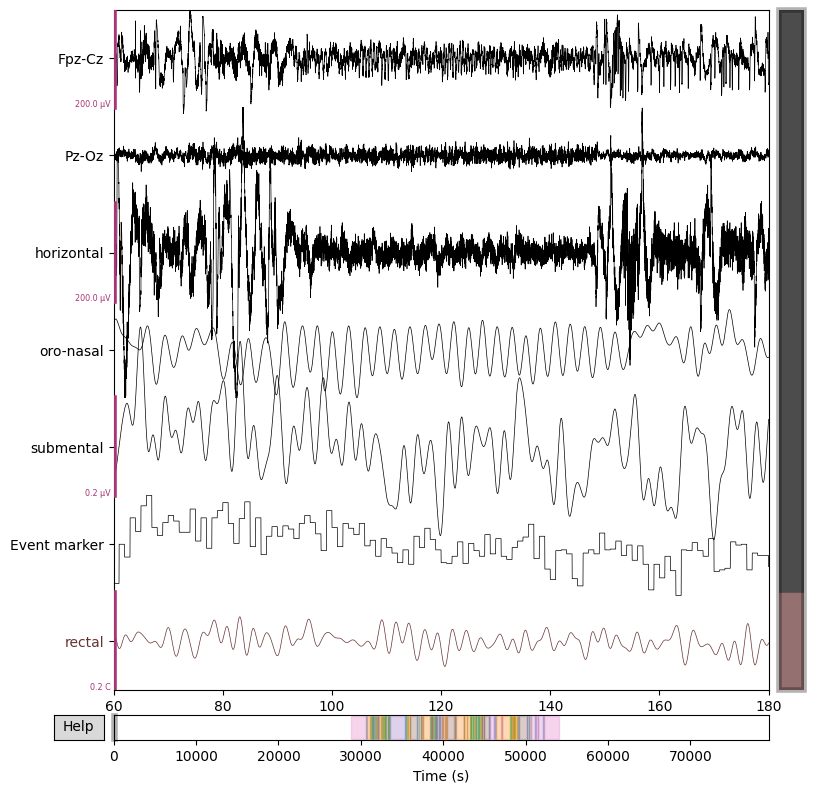

Plot showing the signals form the participant 1


In [ ]:
# Plot the data
raw_train.plot(
    start=60,
    duration=120,
    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1)
)
print("Plot showing the signals form the participant 1")

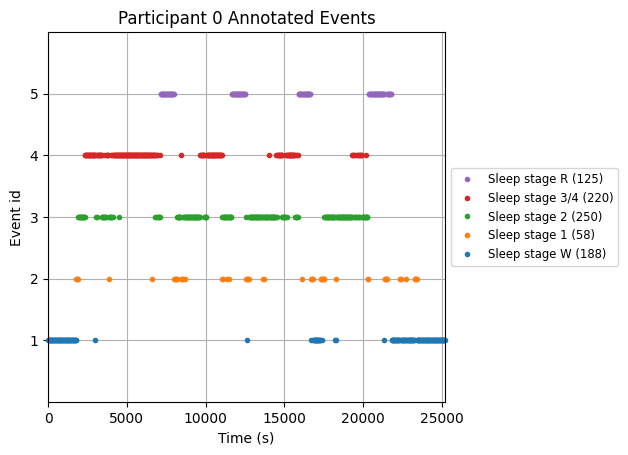

In [ ]:
# plot events across time
fig = mne.viz.plot_events(
    events_train,
    event_id=EVENT_ID,
    sfreq=raw_train.info["sfreq"],
    first_samp=events_train[0, 0],
    show=False,
)
ax = fig.gca()

# Modify the plot a bit
ax.set_title("Participant 0 Annotated Events")

# keep the color-code for further plotting
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.show()

In [ ]:
# visualize participant 0 vs participant 1 PSD by sleep stage
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(EVENT_ID.keys())

for ax, title, epochs in zip([ax1, ax2], ["participant_0", "participant_1"], [epochs_train, epochs_test]):
  for stage, color in zip(stages, stage_colors):
    spectrum = epochs[stage].compute_psd(fmin=0.1, fmax=30.0)
    spectrum.plot(
        ci=None,
        color=color,
        axes=ax,
        show=False,
        average=True,
        amplitude=False,
        spatial_colors=False,
        picks="data",
        exclude="bads",
    )
  ax.set(title=title, xlabel="Frequency (Hz)")
ax1.set(ylabel="µV²/Hz (dB)")
ax2.legend(ax2.lines[2::3], stages)

NameError: name 'plt' is not defined

# Feature Engineering
There are multiple data type, for now we will only use EEG and only calculate power related features.

In [ ]:
def eeg_power_band(epochs, freq_bands=FREQ_BANDS):
  """Calculate relative spectral analysis on the EEG sensors for each epochs"""

  # Calculate the spectrogram
  spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
  psds, freqs = spectrum.get_data(return_freqs=True)

  # Normalization
  psds /= np.sum(psds, axis=-1, keepdims=True)

  # shape of PSDS:
  # (epoch, number of channels (we have two), frequency_bins)
  # We'll slice and average to get the delta to theta bands (5 feature per channel)
  # Therefore we should finish with (epoch, number of channels * number of bands)

  X = []
  # For each frequency band get the mean value and add it to the list X
  for fmin, fmax in freq_bands.values():
    psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
    X.append(psds_band.reshape(len(psds), -1))

  # return a numpy array, by reshuffling the list from a (5,841,2) to a (841,10)
  return np.concatenate(X, axis=1)

# Classification
The classification here is a very simple training with one participant and testing on another.

No cross validation going on here or parameter tuning.

In [ ]:
# Define beforehand what is random here for each of the stage given the data we have.
# This is for the training participant
stages = sorted(EVENT_ID.keys())
random_guess_train = {}
for stage in stages:
  random_guess_train[stage] = epochs_train[stage].__len__() / epochs_train.__len__()

print("Random guess for the training participant: ")
random_guess_train

Random guess for the training participant: 


{'Sleep stage 1': 0.06896551724137931,
 'Sleep stage 2': 0.2972651605231867,
 'Sleep stage 3/4': 0.2615933412604043,
 'Sleep stage R': 0.14863258026159334,
 'Sleep stage W': 0.2235434007134364}

In [ ]:
random_guess_test = {}
for stage in stages:
  random_guess_test[stage] = epochs_test[stage].__len__() / epochs_test.__len__()

print("Random guess for the testing participant: ")
random_guess_test

NameError: name 'stages' is not defined

In [ ]:
# Our Steps are:
# 1. create the feature vector X using the epochs
# 2. Use the random forest classifier
pipe = make_pipeline(
    FunctionTransformer(eeg_power_band, validate=False),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

# Training of the classifier using the participant 0 data
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Testing using the participant 1 data
y_pred = pipe.predict(epochs_test)

y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy score: {acc}")

Using data from preloaded Raw for 841 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Using data from preloaded Raw for 1103 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy score: 0.6854034451495921


                 precision    recall  f1-score   support

  Sleep stage W       0.48      0.98      0.64       157
  Sleep stage 1       0.20      0.23      0.22       109
  Sleep stage 2       0.94      0.78      0.85       562
Sleep stage 3/4       0.78      0.96      0.86       105
  Sleep stage R       0.62      0.23      0.33       170

       accuracy                           0.69      1103
      macro avg       0.60      0.64      0.58      1103
   weighted avg       0.74      0.69      0.68      1103

{'Sleep stage W': 1, 'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3/4': 4, 'Sleep stage R': 5}


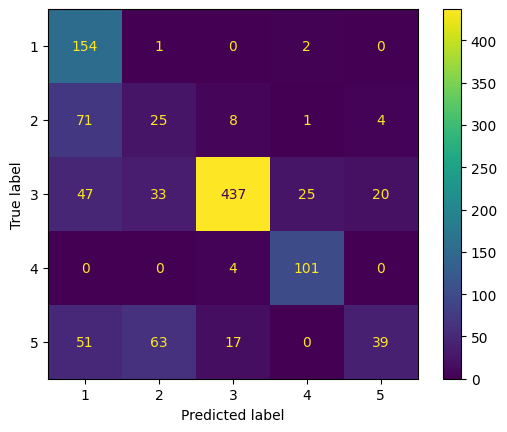

In [ ]:
# Create a confusion matrix and a report on all the metrics
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
print(classification_report(y_test, y_pred, target_names=EVENT_ID.keys()))
print(EVENT_ID)